In [1]:
import os
import cv2
import sys
import numpy as np
import torch

from torch import nn
from torchvision import transforms
from torchinfo import summary
from torch.nn.functional import threshold, normalize
from torch.nn import BCELoss

from tqdm.auto import tqdm





# 1. Data

In [2]:
from pathlib import Path

In [3]:
cod_path = Path("/kaggle/input/cod10k")
train_img_path = cod_path/"COD10K-v2/Train/Images/Image"
train_gt_path = cod_path/"COD10K-v2/Train/GT_Objects/GT_Object"
test_img_path = cod_path/"COD10K-v2/Test/Images/Image"
test_gt_path = cod_path/"COD10K-v2/Test/GT_Objects/GT_Object"

train_img_list = sorted(list(train_img_path.glob("*.jpg")))
train_gt_list = sorted(list(train_gt_path.glob("*.png")))
test_img_list = sorted(list(test_img_path.glob("*.jpg")))
test_gt_list = sorted(list(test_gt_path.glob("*.png")))

## 1.1 Plot example

In [4]:
import random
from PIL import Image
import matplotlib.pyplot as plt

Random index = 2918, Image size_HxW = (768, 1024)


(-0.5, 1023.5, 767.5, -0.5)

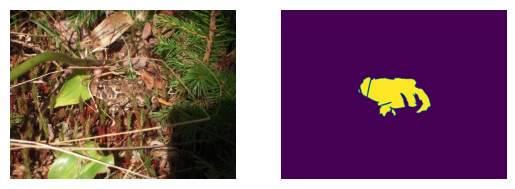

In [5]:
random_idx = random.randint(0,len(train_img_list))
sample_img = train_img_list[random_idx]
sample_gt = train_gt_list[random_idx]
#sample_gt = train_gt_path/f"{sample_img.name[:len(sample_img.name)-3]}png"
(sample_img, sample_gt)

img = Image.open(sample_img)
gt = Image.open(sample_gt)

print(f"Random index = {random_idx}, Image size_HxW = {tuple(reversed(img.size))}")

plt.subplot(1,2,1)
plt.imshow(np.asarray(img))
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(np.asarray(gt))
plt.axis(False)

In [6]:
np.asarray(img).shape

(768, 1024, 3)

## 1.2 Dataset

In [7]:
import numpy as np
from pathlib import Path
from PIL import Image

from torch.utils.data import Dataset
from torch.nn import functional as F

from segment_anything.modeling import Sam
from segment_anything.utils.transforms import ResizeLongestSide

In [8]:
class SamDataset(Dataset):
    def __init__(
        self,
        root_dir: str,
        split: str,
        sam_model: Sam,
        print_internals:bool=False
    ):
        self.root_dir = Path(root_dir)
        self.model = sam_model
        self.device = sam_model.device
        self.transform = ResizeLongestSide(sam_model.image_encoder.img_size)
        self.print_internals = print_internals
                
        if split=="train":
            self.data_dir = self.root_dir/"Train"
        elif split=="test":
            self.data_dir = self.root_dir/"Test"
        
        self.image_dir = self.data_dir/"Images/Image"
        self.gt_dir = self.data_dir/"GT_Objects/GT_Object"
        
        self.unsorted_image_list = list(self.image_dir.glob("*.jpg"))
        self.unsorted_gt_list = list(self.gt_dir.glob("*.png"))
        
        self.sorted_image_list = sorted(self.unsorted_image_list)
        self.sorted_gt_list = sorted(self.unsorted_gt_list)
        
        #print(f"sorted_gt_list : { len(self.sorted_gt_list)}")
        #print(f"sorted_image_list : { len(self.sorted_image_list)}")

        #print(self.sorted_image_list[0:5])
        #print(self.sorted_gt_list[0:5])
        
        assert (len(self.sorted_image_list)==len(self.sorted_gt_list)), "Number of Images and Ground Truths are not same!"
    
    def __getitem__(self, idx):
        
        img = Image.open(self.sorted_image_list[idx])
        img_np = np.asarray(img.convert("RGB"), dtype=np.uint8)
        img_transformed = self.transform.apply_image(img_np)
        img_tensor = torch.as_tensor(img_transformed, device=self.device).permute(2, 0, 1)
        img_preprocessed = self.model.preprocess(img_tensor)
        
        gt = Image.open(self.sorted_gt_list[idx])
        gt_np = np.asarray(gt, dtype=np.uint8)
        gt_tensor = torch.as_tensor(gt_np, device=self.device)
        #gt_transformed = self.transform.apply_image(gt_np)
        #gt_tensor = torch.as_tensor(gt_transformed, device=self.device)
        #gt_preprocessed = self._preprocess_gt(gt_tensor)
        
        bbox = self._get_bbox(np.array(gt))
        bbox_transformed = self.transform.apply_boxes(bbox, gt_np.shape)
        bbox_tensor = torch.as_tensor(bbox_transformed, device=self.device)
                
        if(self.print_internals):
            print('==========================================================================')
            print(f"img: {type(img),img.size}")
            print(f"img_np: {type(img_np),img_np.shape}")
            print(f"img_transformed: {type(img_transformed),img_transformed.shape}")
            print(f"img_tensor: {type(img_tensor),img_tensor.shape, img_tensor.dtype}")
            print(f"img_preprocessed: {type(img_preprocessed),img_preprocessed.shape, img_preprocessed.dtype}")
            print('--------------------------------------------------------------------------')
            print(f"gt: {type(gt),gt.size}")        
            print(f"gt_np: {type(gt_np),gt_np.shape}")        
            #print(f"gt_transformed: {type(gt_transformed),gt_transformed.shape}")
            print(f"gt_tensor: {type(gt_tensor),gt_tensor.shape, gt_tensor.dtype}")
            #print(f"gt_preprocessed: {type(gt_preprocessed),gt_preprocessed.shape,gt_preprocessed.dtype}")
            print('--------------------------------------------------------------------------')
            print(f"bbox: {type(bbox),bbox.shape}")
            print(f"bbox_transformed: {type(bbox_transformed),bbox_transformed.shape}")
            print(f"bbox_tensor: {type(bbox_tensor),bbox_tensor.shape}")
            print('==========================================================================')
        
        item_dict = {'image':img_preprocessed,
                    'original_image_size': tuple(reversed(img.size)),
                    'input_image_size': img_transformed.shape[:2],
                    'bbox': bbox_tensor,
                    'gt': gt_tensor
                    #'gt': gt_preprocessed 
                   }
        #return img_dict,gt_transformed
        return item_dict
    
    def _preprocess_gt(self, gt_tensor):
        """
        Pads the ground truth to make it a square
        """
        h, w = gt_tensor.shape[-2:]
        padh = self.model.image_encoder.img_size - h
        padw = self.model.image_encoder.img_size - w
        gt_preprocessed = F.pad(gt_tensor, (0, padw, 0, padh)).unsqueeze(dim=0).to(torch.float32)
        return gt_preprocessed
    
    def _get_bbox(self, ground_truth_map):
        H, W = ground_truth_map.shape
        try:
            # get bounding box from mask
            y_indices, x_indices = np.where(ground_truth_map > 0)
            x_min, x_max = np.min(x_indices), np.max(x_indices)
            y_min, y_max = np.min(y_indices), np.max(y_indices)
            # add perturbation to bounding box coordinates
            x_min = max(0, x_min - 20)
            x_max = min(W, x_max + 20)
            y_min = max(0, y_min - 20)
            y_max = min(H, y_max + 20)
        except:
            #x_min, y_min, x_max, y_max = 0,0,W,H
            x_min, y_min, x_max, y_max = 0,0,0,0
        bbox = np.array([[x_min, y_min, x_max, y_max]])
    
        return bbox
    
    def __len__(self):
        return len(self.sorted_image_list)


## 2. Model

In [9]:
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor
from segment_anything.modeling import Sam

from torch.utils.data import DataLoader
from torch.nn.functional import threshold,normalize

In [10]:
MODEL_VARIANT = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device is {device}")

Device is cuda


In [11]:
sam_checkpoint_registry = {
    "vit_b":"/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth",
    "vit_l":"/kaggle/input/segment-anything/pytorch/vit-l/1/model.pth",
    "vit_h":"/kaggle/input/segment-anything/pytorch/vit-h/1/model.pth"
}

In [12]:
sam_checkpoint = sam_checkpoint_registry[MODEL_VARIANT]
sam = sam_model_registry[MODEL_VARIANT](checkpoint = sam_checkpoint)
sam.to(device)
pass
#summary(model=sam_b, col_names=['num_params','trainable'])
#summary(model=sam_l)
#summary(model=sam_h, col_names=['num_params','trainable'])

In [13]:
train_dataset = SamDataset(root_dir="/kaggle/input/cod10k/COD10K-v2",
                          split='train',
                          sam_model=sam,
                          print_internals=False)

In [14]:
#train_dataset[0][0].shape, train_dataset[0][1].shape
type(train_dataset[0])

/tmp/ipykernel_24/3196374533.py:47: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  gt_tensor = torch.as_tensor(gt_np, device=self.device)


dict

In [15]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in sam.image_encoder.parameters():
    param.requires_grad = False

In [16]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = 1

# Recreate the classifier layer and seed it to the target device
sam.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [17]:
summary(model=sam, col_names=['num_params','trainable'])

Layer (type:depth-idx)                             Param #                   Trainable
Sam                                                --                        Partial
├─ImageEncoderViT: 1-1                             3,145,728                 False
│    └─PatchEmbed: 2-1                             --                        False
│    │    └─Conv2d: 3-1                            (590,592)                 False
│    └─ModuleList: 2-2                             --                        False
│    │    └─Block: 3-2                             (7,091,328)               False
│    │    └─Block: 3-3                             (7,091,328)               False
│    │    └─Block: 3-4                             (7,104,128)               False
│    │    └─Block: 3-5                             (7,091,328)               False
│    │    └─Block: 3-6                             (7,091,328)               False
│    │    └─Block: 3-7                             (7,104,128)               Fals

In [18]:
def Average(lst): 
        return sum(lst) / len(lst)

In [19]:
train_dataloader = DataLoader(dataset=train_dataset,
                             batch_size=1,
                             shuffle=True)

In [20]:
NUM_EPOCHS = 5
BATCH_SIZE = 500
train_loss = []        # indexed over epochs
for epoch in range(NUM_EPOCHS):
    epoch_loss = []
    print(f'Start of epoch {epoch+1}')
    for idx in range(1,len(train_dataloader)+1):
        loss = 0
        input_dict = next(iter(train_dataloader))
        input_image = input_dict['image']
        box_prompt = input_dict['bbox']
        original_image_size = input_dict['original_image_size']
        input_image_size = input_dict['input_image_size']
        gt_mask = input_dict['gt']
        with torch.no_grad():
            image_embedding = sam.image_encoder(input_image)
            sparce_embeddings, dense_embeddings = sam.prompt_encoder(points=None,
                                                                boxes=box_prompt,
                                                                masks=None)
        low_res_masks, iou_predictions = sam.mask_decoder(image_embeddings=image_embedding,
                                                         image_pe=sam.prompt_encoder.get_dense_pe(),
                                                         sparse_prompt_embeddings=sparce_embeddings,
                                                         dense_prompt_embeddings=dense_embeddings,
                                                         #dense_prompt_embeddings=torch.repeat_interleave(dense_embeddings,batch_size, dim=0),     # batch size is defined above and the repetation of interleave depends upon no in batch size.
                                                         multimask_output=False)
        upscaled_mask = sam.postprocess_masks(masks=low_res_masks,
                                          input_size=input_image_size,
                                          original_size=original_image_size)
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(sam.mask_decoder.parameters()) 
        binary_mask = normalize(threshold(upscaled_mask, 0.0, 0))
        #cod_mask_pred = binary_mask.squeeze().to('cpu').numpy()
        cod_mask_pred = binary_mask.squeeze().to('cpu').detach().numpy()
        cod_mask_gt = gt_mask.squeeze().to('cpu').numpy()
        input_image_np = input_image.squeeze().to('cpu').numpy()
        gt_binary_mask = torch.as_tensor(cod_mask_gt, device = "cuda" if torch.cuda.is_available() else "cpu")
        binary_mask_squeeze = torch.squeeze(binary_mask)
        gt_binary_mask_float = gt_binary_mask.float()
        loss += loss_fn(binary_mask_squeeze, gt_binary_mask_float)
        optimizer.zero_grad()
        if(idx % BATCH_SIZE == 0):
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            loss = 0
            print(f'end of batch {int(idx/BATCH_SIZE)}')
        #print(f"image {i+1}, Loss: {loss.item()}")   
    avg_epoch_loss = Average(epoch_loss) 
    train_loss.append(avg_epoch_loss)
    print(f'End of epoch {epoch+1}')
    #print(f"Batch Loss = avg_batch_loss")
#avg_epoch_loss = Average(train_loss)

Start of epoch 1
end of batch 1
end of batch 2
end of batch 3
end of batch 4
end of batch 5
end of batch 6
end of batch 7
end of batch 8
end of batch 9
end of batch 10
end of batch 11
end of batch 12
End of epoch 1
Start of epoch 2
end of batch 1
end of batch 2
end of batch 3
end of batch 4
end of batch 5
end of batch 6
end of batch 7
end of batch 8
end of batch 9
end of batch 10
end of batch 11
end of batch 12
End of epoch 2
Start of epoch 3
end of batch 1
end of batch 2
end of batch 3
end of batch 4
end of batch 5
end of batch 6
end of batch 7
end of batch 8
end of batch 9
end of batch 10
end of batch 11
end of batch 12
End of epoch 3
Start of epoch 4
end of batch 1
end of batch 2
end of batch 3
end of batch 4
end of batch 5
end of batch 6
end of batch 7
end of batch 8
end of batch 9
end of batch 10
end of batch 11
end of batch 12
End of epoch 4
Start of epoch 5
end of batch 1
end of batch 2
end of batch 3
end of batch 4
end of batch 5
end of batch 6
end of batch 7
end of batch 8
end

## Code to save Model

In [21]:
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

## Saving the Model

In [22]:
# Save a model to file
save_model(model=sam, 
           target_dir="/kaggle/working/",
           model_name="sam_b1.pth")

[INFO] Saving model to: /kaggle/working/sam_b1.pth
